In [1]:
import sys
import numpy as np
import matplotlib.pyplot as plt
import mitsuba as mi 
mi.set_variant("cuda_ad_rgb")
from PDE2D.utils import *
import drjit as dr
from mitsuba import Float,Point2f, PCG32, UInt, Bool
from PDE2D.BoundaryShape import QuadraticBezierShape, load_bunny
from PDE2D.Coefficient import ConstantCoefficient
from PDE2D.BoundaryShape.interaction import *

In [2]:

neumann = [ConstantCoefficient("neumann", 0)]
dirichlet = [ConstantCoefficient("dirichlet", 0)]
shape=  load_bunny(scale = 1, dirichlet = dirichlet, neumann=neumann, conf = 4)

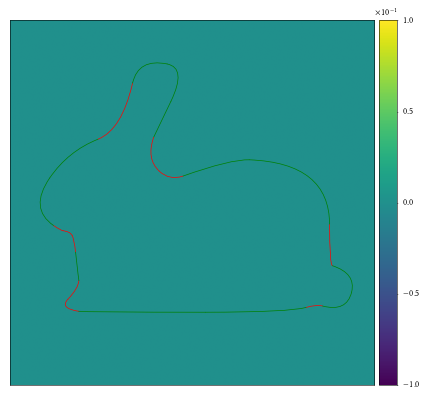

In [3]:
s = 1.3
bbox = [[-1, -1], [1, 1]]
resolution = [512, 512]
image = np.zeros(resolution)
fig, ax = plt.subplots(1,1,figsize = (5,5))
shape.sketch(ax, bbox, resolution)
#shape.sketch_points(ax, bbox, resolution, control_points=False)
#shape.sketch_normals(ax, bbox, resolution, length_vector=1)
#shape.sketch_polyline(ax, bbox, resolution)
plot_image(image, ax)



In [4]:
r = 0.4;
origin =Point2f(0.0, 0)
num_points = 12
points = create_circle_points(origin = origin, radius=r, resolution = num_points, spp = 1, discrete_points=True, centered = True)

In [ ]:
bi = shape.boundary_interaction(points)

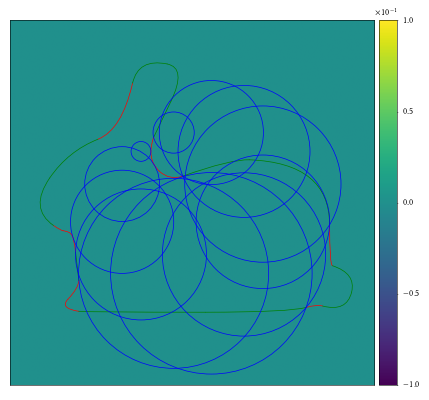

In [6]:
#dist, n, t = shape.get_closest_dist(points)

fig, ax = plt.subplots(1,1,figsize = (5,5))
shape.sketch(ax, bbox, resolution)
#shape.sketch_points(ax, bbox, resolution)
#shape.sketch_normals(ax, bbox, resolution)

dist_s = dist2sketch(bi.r, bbox, resolution)[0].numpy().squeeze()
points_s = point2sketch(points, bbox, resolution).numpy().squeeze()

for i in range(num_points):
    boundary_circle = plt.Circle(points_s[:,i], radius = dist_s[i], fill=False, color="blue")
    #boundary_circle = plt.Circle(points_s, radius = dist_s, fill=False, color="blue")
    ax.add_patch(boundary_circle)
#shape.sketch_polyline(ax, bbox, resolution, color = 'green')
plot_image(image, ax)

In [8]:
sampler = PCG32(dr.width(points), dr.arange(UInt, dr.width(points)))
points =  Point2f(sampler.next_float32(), sampler.next_float32()) -.5
bi = BoundaryInfo(origin = points, on_boundary = Bool(False))
directions = dr.normalize(Point2f(points))
#directions =Point2f(directions[1], -directions[0])
shape.inside = True
ri = shape.ray_intersect(bi, directions)
points_s = point2sketch(points, bbox, resolution).numpy().squeeze()
directions_s = dir2sketch(directions, bbox, resolution).numpy().squeeze()
intersect_s = point2sketch(ri.intersected, bbox, resolution).numpy().squeeze()

/home/ekrem/Environments/invpde-3D/lib/python3.10/site-packages/matplotlib/patches.py:1543: RuntimeWarning: invalid value encountered in scalar divide
  cx = self._dx / distance
/home/ekrem/Environments/invpde-3D/lib/python3.10/site-packages/matplotlib/patches.py:1544: RuntimeWarning: invalid value encountered in scalar divide
  sx = self._dy / distance


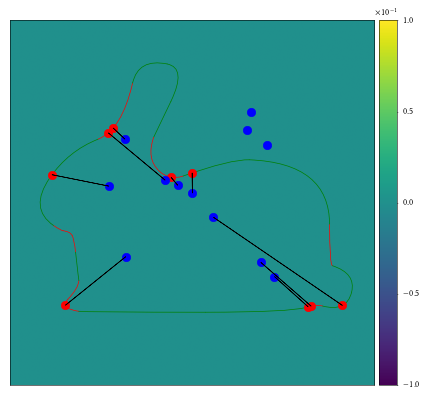

In [9]:
fig, ax = plt.subplots(1,1,figsize = (5,5))
plot_image(image, ax)
shape.sketch(ax, bbox, resolution)
#shape.sketch_points(ax, bbox, resolution)
#shape.sketch_normals(ax, bbox, resolution)
ax.scatter(intersect_s[0], intersect_s[1],  color = "red")
ax.scatter(points_s[0], points_s[1], color = "blue")
for i in range(dr.width(points)):
    ax.arrow(points_s[0, i], points_s[1, i], ri.t.numpy()[i] * directions_s[0, i], ri.t.numpy()[i] * directions_s[1, i])

In [11]:
sampler = PCG32(dr.width(points), dr.arange(UInt, dr.width(points)))
t =  Float(sampler.next_float32())
p1, p2, c = shape.get_interpolation_points(0)
points = shape.interpolate(p1, p2, c, t)
bi = shape.boundary_interaction(points)

directions = - dr.normalize(Point2f(points))
#directions =Point2f(-directions[1], directions[0])
ri = shape.ray_intersect(bi, directions)
points_s = point2sketch(points, bbox, resolution).numpy().squeeze()
directions_s = dir2sketch(directions, bbox, resolution).numpy().squeeze()
intersect_s = point2sketch(ri.intersected, bbox, resolution).numpy().squeeze()
print(t)

[0.0406159, 0.821621, 0.349794, 0.875033, 0.419116, 0.129001, 0.615159, 0.909666, 0.800866, 0.950186, 0.499384, 0.133783]


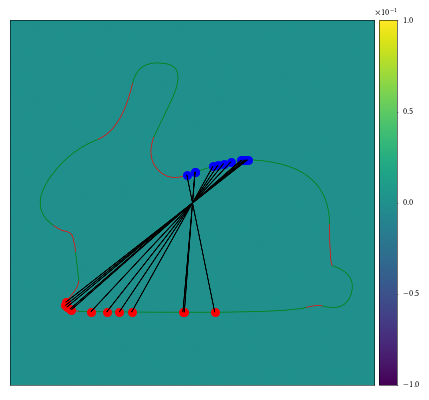

In [12]:
fig, ax = plt.subplots(1,1,figsize = (5,5))
plot_image(image, ax)
shape.sketch(ax, bbox, resolution)
#shape.sketch_points(ax, bbox, resolution)
#shape.sketch_normals(ax, bbox, resolution)
ax.scatter(intersect_s[0], intersect_s[1],  color = "red")
ax.scatter(points_s[0], points_s[1], color = "blue")
t_ = np.maximum(0.05, ri.t.numpy())
for i in range(dr.width(points)):
    ax.arrow(points_s[0, i], points_s[1, i], t_[i] * directions_s[0, i], t_[i] * directions_s[1, i])

In [13]:
points = create_image_points(bbox, resolution, spp = 16)
mask = shape.inside_closed_surface_mask(points)
mask_vals = dr.select(mask, 1., 0.)
image, _ = create_image_from_result(mask_vals, resolution)


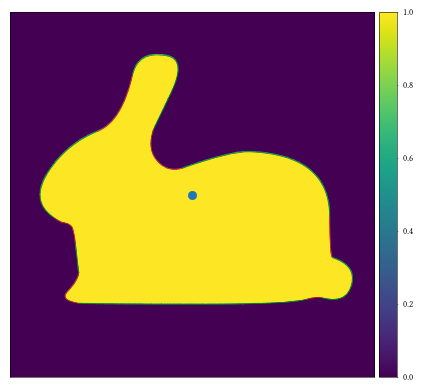

In [14]:
fig, ax = plt.subplots(1,1,figsize = (5,5))
plot_image(image[0], ax)
point_s = point2sketch(shape.bbox_center, bbox, resolution).numpy().squeeze()
ax.scatter(point_s[0], point_s[1])
shape.sketch(ax, bbox, resolution)

In [15]:
num_points = 5
sampler = PCG32(initstate=dr.arange(UInt32,num_points))

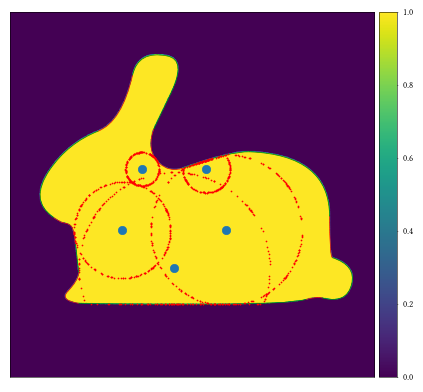

In [16]:
points = create_circle_points(radius = 0.3, resolution=num_points, spp=1, centered=True, discrete_points=True) -Point2f(0.1)
bi = shape.boundary_interaction(points);

fig, ax = plt.subplots(1,1,figsize = (5,5))
plot_image(image[0], ax)
points_s = point2sketch(points, bbox, resolution)
ax.scatter(points_s[0], points_s[1])
shape.sketch(ax, bbox, resolution)

for i in range(200):
    direction, sphere_p, pdf = bi.sample_recursive(sampler.next_float32())
    ri = shape.ray_intersect(bi, direction)
    on_boundary_next = bi.is_star & (ri.t < bi.r)
    points = dr.select(bi.is_star & on_boundary_next, ri.intersected, sphere_p)
    points_s = point2sketch(points, bbox, resolution).numpy()
    ax.scatter(points_s[0], points_s[1], color = "red", s=0.5)

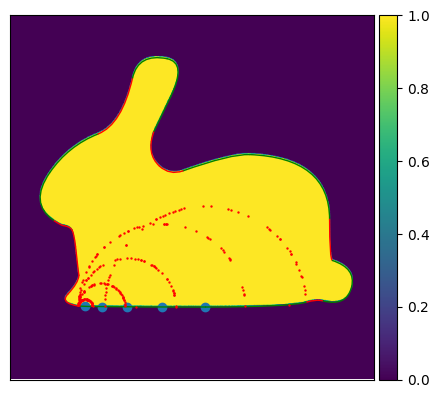

In [16]:
t =  dr.arange(Float, num_points)/num_points
k = 7
p1, p2, c = shape.get_interpolation_points(k)
points = shape.interpolate(p1, p2, c, t)
bi = shape.boundary_interaction(points);

fig, ax = plt.subplots(1,1,figsize = (5,5))
plot_image(image[0], ax)
points_s = point2sketch(points, bbox, resolution)
ax.scatter(points_s[0], points_s[1])
shape.sketch(ax, bbox, resolution)

for i in range(50):
    direction, sphere_p, pdf = bi.sample_recursive(sampler.next_float32())
    
    ri = shape.ray_intersect(bi, direction)
    on_boundary_next = bi.is_star & (ri.t < bi.r)
    points = dr.select(bi.is_star & on_boundary_next, ri.intersected, sphere_p)
    points_s = point2sketch(points, bbox, resolution).numpy()
    ax.scatter(points_s[0], points_s[1], color = "red", s=0.5)

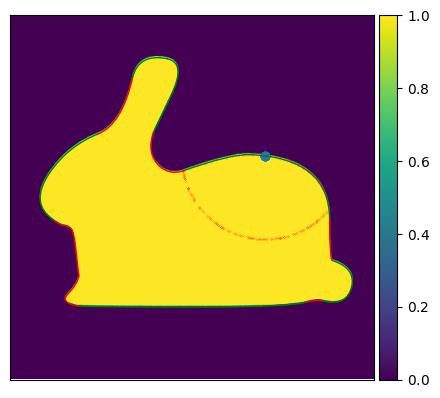

In [17]:

t =  dr.ones(Float, num_points) * 0.1
k = 1
p1, p2, c = shape.get_interpolation_points(k)
points = shape.interpolate(p1, p2, c, t)
bi = shape.boundary_interaction(points);

fig, ax = plt.subplots(1,1,figsize = (5,5))
plot_image(image[0], ax)
points_s = point2sketch(points, bbox, resolution)
ax.scatter(points_s[0], points_s[1])
shape.sketch(ax, bbox, resolution)

for i in range(50):
    direction, sphere_p, pdf = bi.sample_recursive(sampler.next_float32())
    
    ri = shape.ray_intersect(bi, direction)
    on_boundary_next = bi.is_star & (ri.t < bi.r)
    points = dr.select(bi.is_star & on_boundary_next, ri.intersected, sphere_p)
    points_s = point2sketch(points, bbox, resolution).numpy()
    ax.scatter(points_s[0], points_s[1], color = "red", s=0.01)

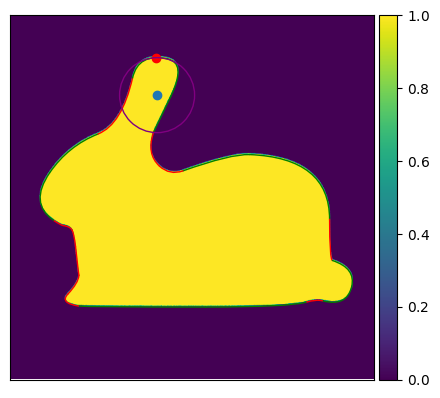

In [18]:
points =Point2f([-0.2, 1.2])
bi = shape.boundary_interaction(points);

fig, ax = plt.subplots(1,1,figsize = (5,5))
plot_image(image[0], ax)
shape.sketch(ax, bbox, resolution)
shape.sketch_curvature(bi, ax, bbox, resolution)


In [19]:
bi.curvature

[4.85504]